## Loading data into files and containers

In [1]:
import os
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
from zipfile import ZipFile
import pandas as pd
from sklearn.metrics import f1_score, precision_score, recall_score
import tensorflow as tf
from tensorflow.keras.layers import Dense, Conv2D, MaxPool2D

### Downloading data set should not need to do know


In [2]:
#!chmod 600 kaggle.json && (ls ~/.kaggle 2>/dev/null || mkdir ~/.kaggle) && cp kaggle.json ~/.kaggle/ && echo 'Done'
#!ls
#!kaggle datasets download --force -d kmader/skin-cancer-mnist-ham10000

In [3]:
archive = 'skin-cancer-mnist-ham10000.zip'
cur_dir = os.getcwd()
a = os.path.join(cur_dir, archive)
print(a)

/content/skin-cancer-mnist-ham10000.zip


In [4]:
#with ZipFile(archive , 'r') as zip_ref:
#    zip_ref.extractall('./')

In [5]:
path_1 = 'HAM10000_images_part_1'
path_2 = 'HAM10000_images_part_2'
path_meta = 'HAM10000_metadata.csv'

### Read data

In [6]:
file_path1 = os.path.join(cur_dir, path_1) #HAM10000_images_part_1
file_path2 = os.path.join(cur_dir, path_2) #HAM10000_images_part_2

len(os.listdir(file_path1)), len(os.listdir(file_path2))

(5000, 5015)

In [7]:
metadata_path = os.path.join(cur_dir, path_meta)
df = pd.read_csv(metadata_path)
df['lesion_id'].unique().shape, df

##
df_ids_img = df[['lesion_id','image_id','dx']]
df_ids_img['dx'].unique()

array(['bkl', 'nv', 'df', 'mel', 'vasc', 'bcc', 'akiec'], dtype=object)

### First Folder to add to Second folder

In [34]:
df_ids_img

,lesion_id,image_id,dx
0,HAM_0000118,ISIC_0027419,bkl
1,HAM_0000118,ISIC_0025030,bkl
2,HAM_0002730,ISIC_0026769,bkl
3,HAM_0002730,ISIC_0025661,bkl
4,HAM_0001466,ISIC_0031633,bkl
...,...,...,...
10010,HAM_0002867,ISIC_0033084,akiec
10011,HAM_0002867,ISIC_0033550,akiec
10012,HAM_0002867,ISIC_0033536,akiec
10013,HAM_0000239,ISIC_0032854,akiec


### Second Folder Processing

In [53]:
num_2 = int( len(os.listdir(file_path2)) ) # Number of images to use

In [54]:
size = (220,220)

imgs_2 = []

In [55]:
target = []

for i, img in enumerate( os.listdir(file_path2) ):
  if( i < num_2 ):
    p_id = img.split('.')[0]
    target.append( df[ df['image_id'] == p_id ]['dx'].iloc[0])
    imgs_2.append( cv.resize( cv.imread( os.path.join(file_path2, img) ), size ) )



In [56]:
# Add items to even out distribution
# Distribution to be around half
items = 2000
cnt = 0

for f in os.listdir(file_path1) :
  p_id = f.split('.')[0]
  dx = df_ids_img[ df_ids_img[ 'image_id' ] == p_id ]['dx'].iloc[0]
  if not ( dx == 'nv' or dx == 'bkl' or dx == 'df' or dx == 'vasc' ) and items > 0:
    cnt += 1
    # Append to list to even out distribution
    target.append( dx )
    imgs_2.append( cv.resize( cv.imread( os.path.join( file_path1, f ) ), size ) )
    items - 1

cnt

884

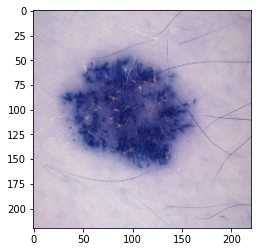

In [57]:
plt.imshow(imgs_2[0])

In [58]:
len(group_2), len(imgs_2), len(target)

(5899, 5899, 5899)

In [59]:
group_2 = [0 for i in range(len( imgs_2 ) ) ] 
for i in range(len( imgs_2 )):
    group_2[i] = [ imgs_2[i], target[i] ]

# Shuffle
np.random.shuffle(group_2)

# Ungroup
for i in range(len( imgs_2 )):
    imgs_2[i] = group_2[i][0]
    target[i] = group_2[i][1]



In [60]:
target_binary = []
for k in target:
  if k == 'nv' or k == 'bkl' or k == 'df' or k == 'vasc':
    target_binary.append(0)
  else:
    target_binary.append(1)
    
for k in range(5):
    print(target_binary[k])


0
1
1
0
0


In [52]:
cnt = [0,0]
for k in target_binary:
  cnt[k] += 1

cnt, cnt[0] + cnt[1]

([3945, 1954], 5899)

### Split data

In [61]:
train_split = int ( ( num_2 + items ) * 0.8 )
train_x = np.array(imgs_2[:train_split])
train_y = np.array(target_binary[:train_split])

val_x = np.array(imgs_2[train_split:])
val_y = np.array(target_binary[train_split:])

In [62]:
train_y_bin = np.array(target_binary[:train_split])

val_y_bin = np.array(target_binary[train_split:])

len(val_y_bin), len( train_y )

(287, 5612)

In [63]:
cnt = [0 for k in range(2)]
for k in target_binary:
    cnt[k] += 1

cnt, 3431 / (3431 + 1569)

([3945, 1954], 0.6862)

In [64]:
filter1 = 16
filter2 = 32
filter3 = 64

input_size = (size[0], size[1], 3)
pool_size = (2,2)

In [107]:
#First make our layers
input_layer = tf.keras.layers.Input(shape = input_size, name = 'input')
conv1 = Conv2D(filter1, (8,8), activation='relu', padding='same', name = 'c1')(input_layer)
pool1 = MaxPool2D(pool_size, name = 'p1')(conv1)
conv2 = Conv2D(filter2, (4,4), activation = 'relu', padding = 'same', name = 'c2')(pool1)
pool2 = MaxPool2D(pool_size, name = 'p2')(conv2)
conv3 = Conv2D(filter3, (2,2), activation = 'relu', padding = 'same', name = 'c3')(pool2)
pool3 = MaxPool2D(pool_size, name = 'p3')(conv3)
flatten = tf.keras.layers.Flatten(name = 'flatten')(pool3)
dense1 = Dense(128,activation = 'relu',name = 'd1')(flatten)
output_layer = Dense(1, activation = 'sigmoid',name = 'out')(dense1)

In [116]:
model2 = tf.keras.Model(input_layer, output_layer, name = 'Model2')

optimizer = tf.keras.optimizers.Adam(learning_rate=1e-7)
model2.compile(
    optimizer = 'Adam',
    loss = 'binary_crossentropy', # Multiclass Problem
    metrics = 'accuracy',
)

model2.summary()

Model: "Model2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input (InputLayer)          [(None, 220, 220, 3)]     0         
                                                                 
 c1 (Conv2D)                 (None, 220, 220, 16)      3088      
                                                                 
 p1 (MaxPooling2D)           (None, 110, 110, 16)      0         
                                                                 
 c2 (Conv2D)                 (None, 110, 110, 32)      8224      
                                                                 
 p2 (MaxPooling2D)           (None, 55, 55, 32)        0         
                                                                 
 c3 (Conv2D)                 (None, 55, 55, 64)        8256      
                                                                 
 p3 (MaxPooling2D)           (None, 27, 27, 64)        0    

In [117]:
early_stop = tf.keras.callbacks.EarlyStopping(
    monitor='accuracy', patience = 7
    )

EPOCH = 100

#Train the model
history2 = model2.fit(
    train_x,
    train_y_bin,
    epochs = EPOCH,
    batch_size = 512,
    callbacks = [early_stop]
)

Epoch 1/100
11/11 [==============================] - 4s 307ms/step - loss: 14.2717 - accuracy: 0.6201
Epoch 2/100
11/11 [==============================] - 3s 306ms/step - loss: 1.2855 - accuracy: 0.7135
Epoch 3/100
11/11 [==============================] - 3s 304ms/step - loss: 0.7262 - accuracy: 0.7060
Epoch 4/100
11/11 [==============================] - 3s 306ms/step - loss: 0.5956 - accuracy: 0.7252
Epoch 5/100
11/11 [==============================] - 3s 305ms/step - loss: 0.5328 - accuracy: 0.7509
Epoch 6/100
11/11 [==============================] - 3s 306ms/step - loss: 0.4872 - accuracy: 0.7623
Epoch 7/100
11/11 [==============================] - 3s 302ms/step - loss: 0.4567 - accuracy: 0.7764
Epoch 8/100
11/11 [==============================] - 3s 303ms/step - loss: 0.4274 - accuracy: 0.7924
Epoch 9/100
11/11 [==============================] - 3s 303ms/step - loss: 0.4017 - accuracy: 0.8042
Epoch 10/100
11/11 [==============================] - 3s 305ms/step - loss: 0.3811 - accur

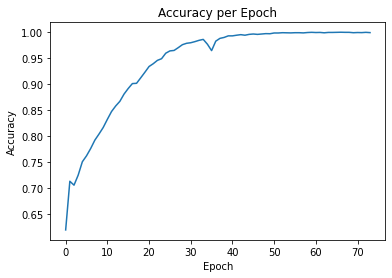

In [118]:
plt.title("Accuracy per Epoch")
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.plot(range(0,len(history2.history['accuracy'])), history2.history['accuracy'])


In [119]:
predictions = model2.predict(val_x)

(array([172.,   8.,   4.,   1.,   6.,   7.,   5.,   5.,   8.,  71.]),
 array([8.6686865e-23, 1.0000000e-01, 2.0000000e-01, 3.0000001e-01,
        4.0000001e-01, 5.0000000e-01, 6.0000002e-01, 6.9999999e-01,
        8.0000001e-01, 8.9999998e-01, 1.0000000e+00], dtype=float32),
 <a list of 10 Patch objects>)

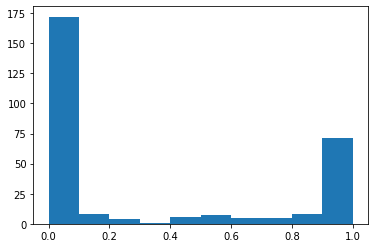

In [120]:
plt.hist(predictions)

In [121]:
predictions2 = model2.predict(val_x)
for k in range(3):
  print(predictions2[k])


[0.00208527]
[7.829586e-10]
[0.04372333]


In [122]:
preds2 = []
for k in predictions2:
  max = 0
  idx = -1
  max_idx = 0
  for i in k:
    idx += 1
    if( i > max ):
      max_idx = idx
      max = i
  preds2.append(max_idx)

In [123]:
percent = [0.05*i for i in range(1,10)]
for p in percent:
  prediction = [0 if k < p else 1 for k in predictions]

  f1 = f1_score(val_y, prediction)
  prec = precision_score(val_y, prediction)
  rec = recall_score(val_y, prediction)

  print(f'The f1 score is {f1} the \n \
        precision is {prec} and the \n \
        recall is {rec}')
  print(f' This is with threshold {p}\n------------------------------\n')


The f1 score is 0.5961538461538461 the 
         precision is 0.5 and the 
         recall is 0.7380952380952381
 This is with threshold 0.05
------------------------------

The f1 score is 0.5829145728643216 the 
         precision is 0.5043478260869565 and the 
         recall is 0.6904761904761905
 This is with threshold 0.1
------------------------------

The f1 score is 0.5773195876288659 the 
         precision is 0.509090909090909 and the 
         recall is 0.6666666666666666
 This is with threshold 0.15000000000000002
------------------------------

The f1 score is 0.5863874345549738 the 
         precision is 0.5233644859813084 and the 
         recall is 0.6666666666666666
 This is with threshold 0.2
------------------------------

The f1 score is 0.5775401069518716 the 
         precision is 0.5242718446601942 and the 
         recall is 0.6428571428571429
 This is with threshold 0.25
------------------------------

The f1 score is 0.5775401069518716 the 
         precision